In [53]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
mpl.rcParams["figure.figsize"] = (12, 8)

In [45]:
pd.options.display.max_rows = 1000

## Cellbender and FastCAR comparison

In this notebook I'm comparing 2 ambient RNA correcting packages: [FastCAR](https://github.com/LungCellAtlas/FastCAR) and [Cellbender](https://cellbender.readthedocs.io/en/latest/introduction/index.html)

FastCAR finds genes that are expressed in all empty droplets with probability _p_ and that way determines which counts to subtract.

Cellbender trains a model of gene expression in the count matrix as negative binomial distribution with mean expressed as a sum of cell-originating expression with added ambient levels for each gene and randomly swapped barcodes. The model and inference are quite similar to scVI. The output is rounded to integers. This algorithm also calls cells, instead of using Cellranger (10x Genomics).

For this notebook I'm focusing on `SSc_C3` sample, as it has MRC1 lowly expressed in T cells and has a MALAT1+ cluster of macrophages

Questions:
1. Will Cellbender remove MRC1 from T cells?
2. Will Cellbender correct MALAT1 similarly?

### 1. Load FastCAR dataset

In [2]:
ds = sc.read_h5ad("../../data/01ssc-bal/scanpy/SSc_C3/SSc_C3.h5ad")

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


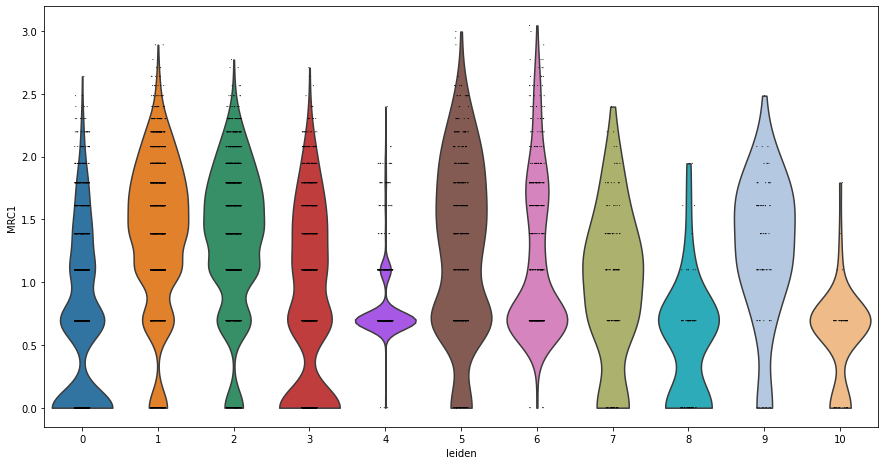

In [6]:
sc.pl.violin(ds, "MRC1", groupby="leiden")

Cluster 4 is T cells. Strangely, Clusters 0 and 3 have cells with zero expression of MRC1, but most of other clusters have cells that express MRC1 at least at a low level

### 2. Load Cellbender dataset

In [8]:
ds2 = sc.read_h5ad("../../data/01ssc-bal/scanpy-cb/SSc_C3/SSc_C3.h5ad")

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


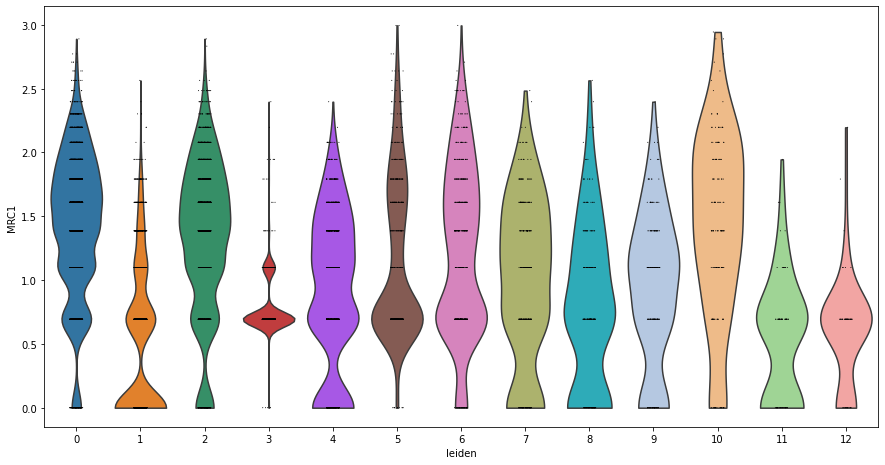

In [77]:
sc.pl.violin(ds2, "MRC1", groupby="leiden")

Clusters are different in this object. T cells in Cluster 3 still have the same pattern of expression of MRC1.

### 3. Number of cells/genes in FastCAR object

In [11]:
ds.shape

(9130, 16638)

### 4. Number of cells/genes in Cellbender object

In [12]:
ds2.shape

(9245, 16551)

Cellbender brought additional 100 cells (after 200 genes filtering)

### 5. nUMI to nGenes plots

Text(0.5, 0, 'Number of UMI')

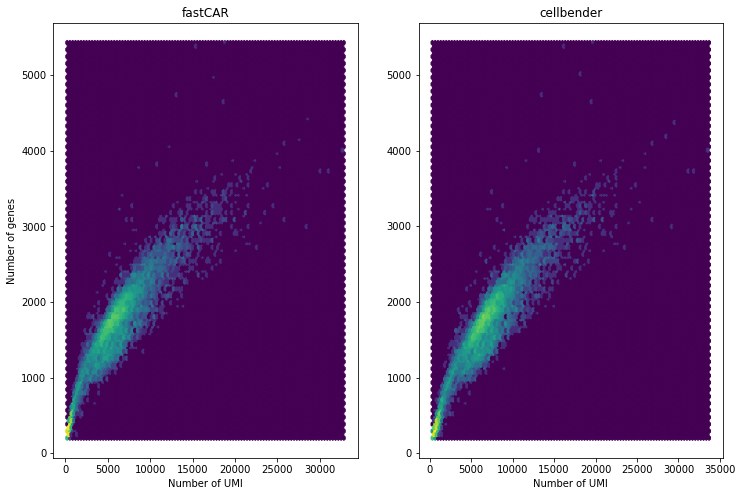

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hexbin(ds.obs.total_counts, ds.obs.n_genes, bins="log")
axes[0].set_xlabel("Number of UMI")
axes[0].set_ylabel("Number of genes")
axes[0].set_title("fastCAR")
axes[1].hexbin(ds2.obs.total_counts, ds2.obs.n_genes, bins="log")
axes[1].set_title("cellbender")
axes[1].set_xlabel("Number of UMI")

### 6. What did FastCAR correct?

Load raw data from Cellranger output

In [24]:
raw_c3 = sc.read_10x_h5("../../data/01ssc-bal/cellranger/SSc_C3/outs/raw_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [32]:
raw_c3.var_names_make_unique(join=".")
raw_c3.var_names = raw_c3.var_names.str.replace("_", "-")
raw_c3.obs_names = "SSc_C3_" + raw_c3.obs_names.str.replace("-\d+$", "")

Subtract FastCAR corrected counts from it, and for each gene compute:
 * mean correction (total cells)
 * standard deviation of correction (total cells)
 * all corrected counts
 * number of corrected cells
 * mean applied correction (corrected cells)

In [73]:
fastcar_corr = raw_c3[ds.obs_names, ds.var_names].X - ds.layers["counts"]
fastcar = pd.DataFrame(index=ds.var_names)
fastcar["mean_total"] = fastcar_corr.mean(axis=0).A1
fastcar["std_total"] = np.std(fastcar_corr.todense(), axis=0).A1
fastcar["sum"] = fastcar_corr.sum(axis=0).A1
fastcar["count"] = (fastcar_corr > 0).sum(axis=0).A1
fastcar["mean"] = fastcar["sum"] / fastcar["count"]
fastcar = fastcar.loc[fastcar["count"] > 0, :]

Top 30 by `mean_total`

In [78]:
fastcar.sort_values("mean_total", ascending=False).iloc[:30, :]

,mean_total,std_total,sum,count,mean
MALAT1,84.473305,37.216206,771235.0,9101,84.741783
FTL,73.652122,23.630026,672412.0,9130,73.648628
FTH1,48.298759,15.581644,440997.0,9130,48.301971
MT-CO1,47.138504,16.860165,430355.0,9107,47.255409
MT-CO3,38.526665,16.630743,351754.0,9046,38.885033
MT-CO2,35.973473,14.139979,328447.0,9090,36.132782
MT-ND4,27.345169,11.844048,249658.0,9032,27.641497
MT-ND2,27.234198,10.820304,248643.0,9059,27.447069
MT-ND3,24.269663,14.458464,221583.0,9025,24.552134
TMSB4X,23.073122,5.263078,210650.0,9125,23.084932


How many genes are corrected?

In [83]:
fastcar.shape

(72, 5)

### 7. What did Cellbender correct?

In [70]:
cellbender_corr = raw_c3[ds2.obs_names, ds2.var_names].X - ds2.layers["counts"]
cellbender = pd.DataFrame(index=ds2.var_names)
cellbender["mean_total"] = cellbender_corr.mean(axis=0).A1
cellbender["std_total"] = np.std(cellbender_corr.todense(), axis=0).A1
cellbender["sum"] = cellbender_corr.sum(axis=0).A1
cellbender["count"] = (cellbender_corr > 0).sum(axis=0).A1
cellbender["mean"] = cellbender["sum"] / cellbender["count"]
cellbender = cellbender.loc[cellbender["count"] > 0, :]

Did Cellbender correct MRC1 expression?

In [71]:
cellbender.loc["MRC1", :]

mean_total     0.005084
std_total      0.074099
sum           47.000000
count         45.000000
mean           1.044444
Name: MRC1, dtype: float64

Only in 45 cells for 1 count

Top 30 by `mean_total`

In [79]:
cellbender.sort_values("mean_total", ascending=False).iloc[:30, :]

,mean_total,std_total,sum,count,mean
FTL,23.290047,8.511477,215316.0,9245,23.289995
FTH1,12.950779,4.978649,119729.0,9245,12.950676
TMSB4X,5.293284,2.018629,48937.0,9238,5.297359
APOC1,1.260474,0.720929,11653.0,8457,1.377912
EEF1A1,1.111537,0.619159,10276.0,8489,1.210508
B2M,1.050860,0.488921,9715.0,8497,1.143345
TMSB10,1.010722,0.619836,9344.0,8037,1.162623
RPLP1,0.837004,0.508586,7738.0,7297,1.060436
MT-CO1,0.812541,0.553875,7512.0,6904,1.088065
RPL41,0.771015,0.505920,7128.0,6819,1.045315


How many genes are corrected?

In [82]:
cellbender.shape

(5531, 5)

### 8. Conclusions

Cellbender is much more mild in its corrections (compare columns `sum`, `mean`). It agrees with FastCAR on FTL, FTH1 and TMSB4X, but not so much on the other genes.

Questions:
1. Will Cellbender remove MRC1 from T cells?
No. It does some correction of MRC1, but not to the degree that removes MRC1 from T cells. I think this could be explained by the strange notion that some macrophages have 0 MRC1, so it is hard to say that MRC1 is in the background.

2. Will Cellbender correct MALAT1 similarly?
No. See below for MALAT1 volcano plots

MALAT1 in FastCAR

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


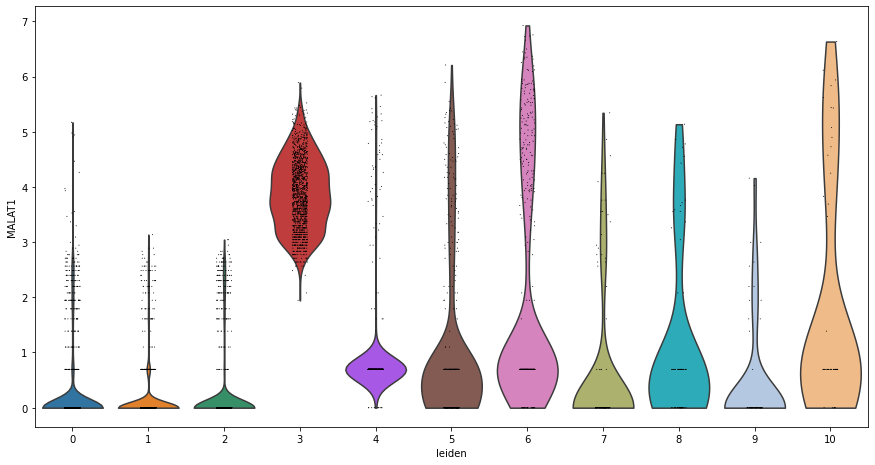

In [80]:
sc.pl.violin(ds, "MALAT1", groupby="leiden")

MALAT1 in Cellbender

/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/projects/b1038/Pulmonary/nmarkov/ssc-v2/code/.venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


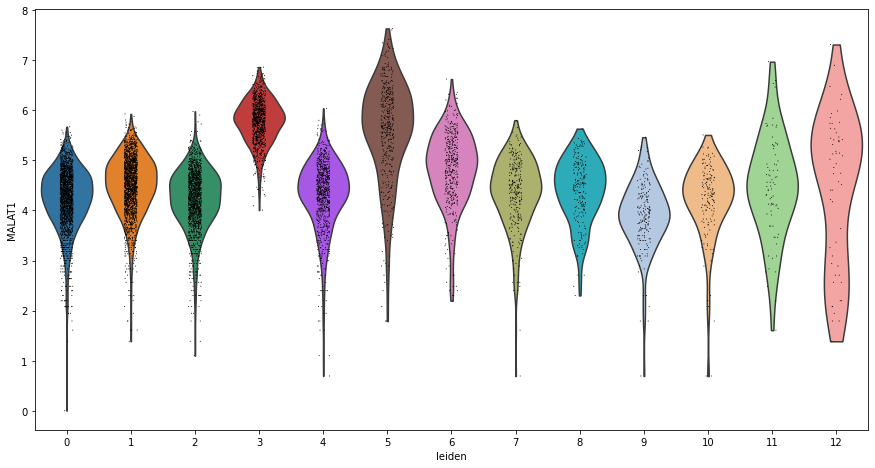

In [81]:
sc.pl.violin(ds2, "MALAT1", groupby="leiden")

### 9. Conclustions 2

Overall, Cellbender seems to do a more accurate job. It's runtime is ~2 hours per sample. We should include it in the pipeline for the lab.

Open question: should we reprocess all samples with Cellbender for SSc project?